## Can we predict better fish decay if we include human data?

In [1]:
import numpy as np
import pandas as pd
from optimalcodon.projects.optrules import utils
from optimalcodon.codons import codon_composition, generate_codons

# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, make_scorer

import matplotlib.pyplot as plt

## Prepare Data

In [2]:
decay, orfs = utils.load_endogenous_data("../../../190115-CodonOptimalityRules/data/190416-DecayProfilesANDEndogenousDataSets/")
decay.sample(10)

loading decay profiles ...
loading orfs ...


/n/projects/smedina/packages/optimalcodon/optimalcodon/projects/optrules/utils.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([fish, human], ignore_index=True)


,Gene_ID,decay_rate,std.error,datatype,cell_type,specie
34581,GCGGTGACCCCTCTGTTTCCTGGG,-0.016613,0.021997,orf-ome,k562,human
11544,ENSDARG00000092898,-0.133196,0.051329,endogenous,embryo,fish
45682,AATGTTTAAATGAGGAGGAAAATG,0.031188,0.043353,orf-ome,293t,human
62778,ENSG00000100083,0.036957,0.017832,endogenous,293t,human
35412,ACTCTCTGTTATTACCTATAAACG,-0.086241,0.042039,orf-ome,k562,human
10653,ENSDARG00000086628,-0.603501,0.107589,endogenous,embryo,fish
16451,ENSG00000100612,-0.056099,0.009210,slam-seq,k562,human
11628,ENSDARG00000093496,-0.256854,0.033332,endogenous,embryo,fish
13191,ENSDARG00000100791,-0.217415,0.051027,endogenous,embryo,fish
13170,ENSDARG00000100718,0.077800,0.016001,endogenous,embryo,fish


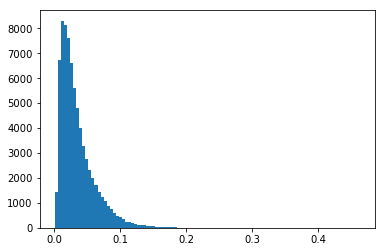

In [3]:
# this can be a predictor for genes withou this we can impute the median
plt.hist(decay['std.error'], bins=100);

In [4]:
# meta is use-less
orfs = orfs.drop(['datatype', 'specie'], axis=1)

# compute the codon composition
# this functionality can be added to the sklearn pipeline
orfs = (
    pd.concat([orfs, codon_composition(orfs.cds)], axis=1)
    .drop('cds', axis=1)
)


# merge predictors and response variable
data = pd.merge(decay, orfs, on="Gene_ID").drop(['std.error', 'Gene_ID'], axis=1)

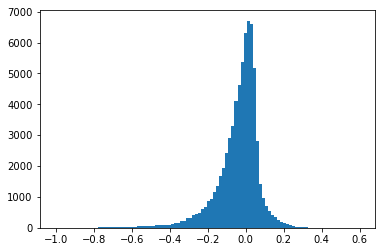

In [5]:
plt.hist(data.decay_rate, bins=100);

In [6]:
# drop outliers
data = data[abs(data.decay_rate) < .5 ]

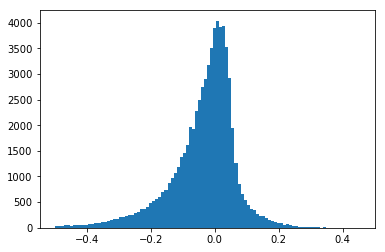

In [7]:
plt.hist(data.decay_rate, bins=100);

In [8]:
## Scale the response variable

In [ ]:
def my_decay_scaler(grp):
    # scale the decay rate
    grp['decay_rate'] = (grp.decay_rate - grp.decay_rate.mean()) / grp.decay_rate.std()
    return grp
    
data = data.groupby(['datatype', 'cell_type', 'specie']).apply(my_decay_scaler)

In [ ]:

data_train, data_test = train_test_split(data, test_size=0.3)

X_train = data_train.drop(['decay_rate'], axis=1)
y_train = data_train.decay_rate

y_test = data_test.decay_rate
X_test = data_test.drop(['decay_rate'], axis=1)

In [ ]:
X_test.shape

(20478, 67)

## Data Pre-processing

### Categorical Features

+ One hot encoding


### Codon Features

+ L2 normalization
+ Scaling

In [ ]:
X_test.head()

,datatype,cell_type,specie,AAA,AAC,AAG,AAT,ACA,ACC,ACG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
39097,orf-ome,k562,human,4,1,2,4,4,1,0,...,0,1,0,2,3,3,1,1,1,1
924,endogenous,embryo,fish,54,33,51,45,55,9,13,...,17,46,1,7,8,3,26,17,24,30
11471,endogenous,embryo,fish,10,6,7,4,3,10,3,...,6,7,0,2,4,4,2,4,3,1
38813,orf-ome,k562,human,3,6,2,3,3,5,0,...,0,1,0,1,3,5,2,1,1,3
64648,endogenous,293t,human,2,19,13,5,6,13,13,...,8,5,1,27,19,5,0,36,3,6


## The pipeline

In [ ]:
num_features = generate_codons()
cat_features = ['specie', 'datatype', 'cell_type']

num_pipeline = Pipeline([
    ('l2_norm', Normalizer(norm='l2')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder())
])

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

full_pipeline = Pipeline(steps=[
    ('preproc1', preprocessor_1),
    ('interactions', PolynomialFeatures()),
    ('zerovar', VarianceThreshold(0)),
    ('scaler', StandardScaler()),
    ('pls', PLSRegression(n_components=10))
])

## Grid Search

In [ ]:
param_grid = dict(
    pls__n_components=list(range(2, 21)),
    interactions__degree = [2, 3],
    interactions__interaction_only = [True, False]
)

grid_search = GridSearchCV(
    full_pipeline,
    param_grid=param_grid,
    cv=10,
    verbose=10,
    n_jobs=32,
    scoring=make_scorer(r2_score)
)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:  1.7min


In [ ]:
print(grid_search.best_estimator_)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test).reshape(1, -1)

In [ ]:
plt.hist(y_test, bins=100);

In [ ]:
plt.scatter(y_pred, y_test, alpha=1/5);

In [ ]:
preds = data_test.drop(generate_codons(), axis=1).assign(y_pred=y_pred[0])

In [ ]:
preds.to_csv('preds.csv', index=False)

In [ ]:
##
cv_res = pd.DataFrame(grid_search.cv_results_)

In [ ]:
cv_res.to_csv("cv_res.csv", index=False)